# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import ndimage
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_orig, y_train = train['features'], train['labels']
X_valid_orig, y_valid = valid['features'], valid['labels']
X_test_orig, y_test = test['features'], test['labels']

    

In [3]:
def rgb2gray(rgb):
    # https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    # Y' = 0.299 R + 0.587 G + 0.114 B
    result = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return result.reshape((rgb.shape[0], rgb.shape[1], rgb.shape[2], 1))

In [4]:
X_train = rgb2gray(X_train_orig / 255.0)
X_valid = rgb2gray(X_valid_orig / 255.0)
X_test = rgb2gray(X_test_orig / 255.0)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
signnames_file = 'signnames.csv'
signnames_data = pd.DataFrame.from_csv(signnames_file)

print ('Rows: ' + str(signnames_data.shape[0]))

Rows: 43


In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train_orig.shape[0]

# TODO: Number of testing examples.
n_test = X_test_orig.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train_orig.shape[1:])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = signnames_data.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [46]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

def visualize_data(X, y, visualize_class_num=5, cmap=None):
    if cmap == 'gray':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    fig, axes = plt.subplots(nrows=n_classes, ncols=visualize_class_num, figsize=(visualize_class_num*2, n_classes*1))
    plt.setp(axes.flat, xticks=[], yticks=[])

    for c, plt_row in zip(range(n_classes), axes):
        X_filtered_by_class = X[y == c]
        if len(X_filtered_by_class) < 1:
            continue
        
        images = X_filtered_by_class[np.random.choice(X_filtered_by_class.shape[0], visualize_class_num)]

        plt_row[0].set_title('Class ' + str(c) + ': ' + signnames_data.get_value(c, 'SignName'), size=8)
        #plt_row[0].set_xlabel('Class ' + str(c) + ': ' + signnames_data.get_value(c, 'SignName'), size=8)

        for img, col_idx in zip(images, range(visualize_class_num)):
            plt_row[col_idx].imshow(img, cmap=cmap)

    plt.tight_layout()

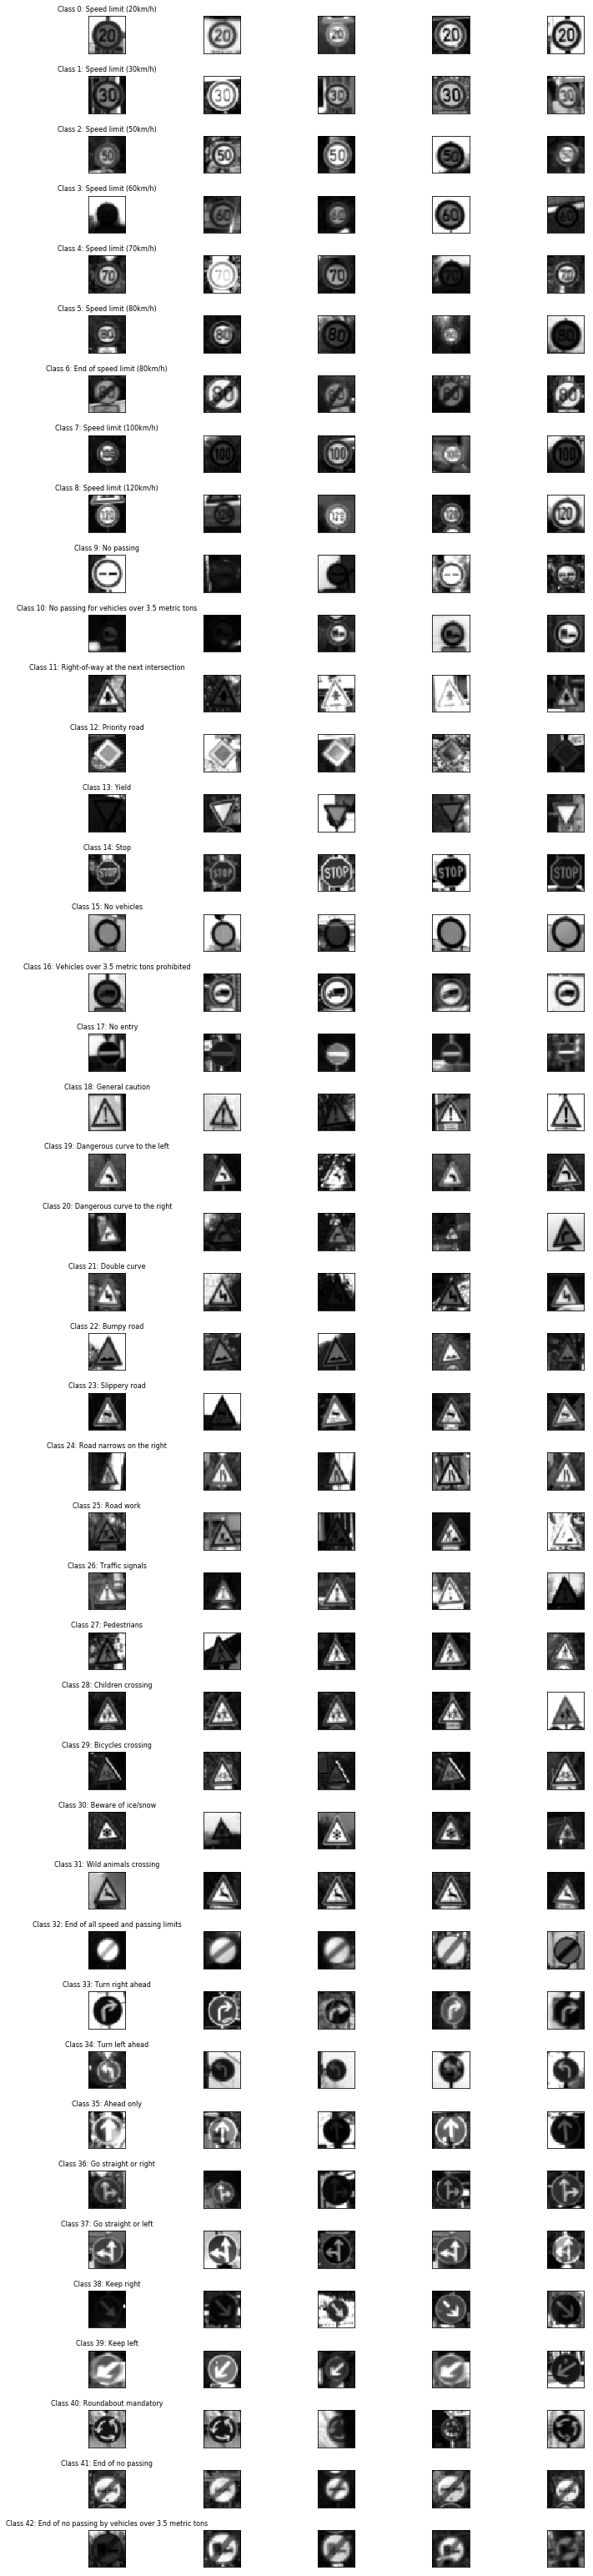

In [8]:
visualize_data(X_train, y_train, cmap='gray')

### Check balance of the Dataset

In [9]:
def check_balance(dataset_labels, dataset_name, num_classes):
    items_per_classes = []

    for c in range(num_classes):
        items_per_classes.append(len(dataset_labels[dataset_labels == c]))

    plt.figure()
    plt.bar(np.arange(num_classes), items_per_classes)
    max_items_per_classes = max(items_per_classes)
    plt.axis([0, num_classes, 0, 1.1 * max_items_per_classes])
    plt.title("Number of samples for each class for " + dataset_name + '. Total #: ' + str(np.sum(items_per_classes, axis=0)))
    plt.grid(True)

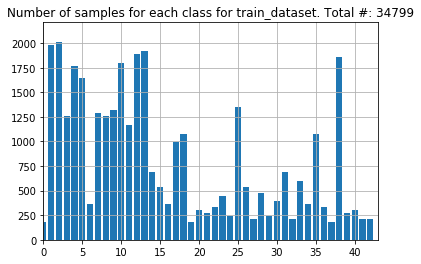

In [10]:
# we expect the data to be balanced across classes.
check_balance(y_train, 'train_dataset', n_classes)
#check_balance(y_valid, 'valid_dataset', n_classes)
#check_balance(y_test, 'test_dataset', n_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [39]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def mean_substraction(X, mean):
    # subtracting the mean across every individual feature in the data
    #X -= np.mean(X, axis=0)
    X -= mean
    return X

def normalization(X, std):
    #X /= np.std(X, axis=0)
    X /= std
    return X

def preprocess_chain(dataset, mean, std):
    #dataset = dataset / 255.0
    #dataset = rgb2gray(dataset)    
    dataset = mean_substraction(dataset, mean)
    dataset = normalization(dataset, std)
    return dataset


In [40]:
# X_train_preprocessed = preprocess_chain(X_train)
# X_valid_preprocessed = preprocess_chain(X_valid)
# X_test_preprocessed = preprocess_chain(X_test)

# http://cs231n.github.io/neural-networks-2/
# An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) 
# must only be computed on the training data, and then applied to the validation / test data. 
# E.g. computing the mean and subtracting it from every image across the entire dataset 
# and then splitting the data into train/val/test splits would be a mistake. 
# Instead, the mean must be computed only over the training data and then subtracted equally 
# from all splits (train/val/test).
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_preprocessed = preprocess_chain(X_train, mean, std)
X_valid_preprocessed = preprocess_chain(X_valid, mean, std)
X_test_preprocessed = preprocess_chain(X_test, mean, std)


### Model Architecture

Use LeNet defined in an external python source LeNet.py

In [58]:
from LeNet import LeNetConfig, LeNet

num_classes = n_classes
input_dim = X_train_preprocessed.shape[1:]

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


In [41]:
# Try default LeNet model
params = {'num_epochs': 10}
lenet_config = LeNetConfig(input_dim, num_classes, params)
lenet = LeNet(lenet_config)
(history, valid_loss, valid_accuracy) = lenet.fit(X_train_preprocessed, y_train, X_valid_preprocessed, y_valid)
#lenet.eval_accuracy(X_valid_preprocessed, y_valid)

Training...

EPOCH 1 ...
Train Loss: 1.590164
Train Accuracy = 0.857
Validation Loss = 0.774
Validation Accuracy = 0.793

EPOCH 2 ...
Train Loss: 0.378041
Train Accuracy = 0.941
Validation Loss = 0.550
Validation Accuracy = 0.847

EPOCH 3 ...
Train Loss: 0.209075
Train Accuracy = 0.943
Validation Loss = 0.526
Validation Accuracy = 0.863

EPOCH 4 ...
Train Loss: 0.146012
Train Accuracy = 0.972
Validation Loss = 0.471
Validation Accuracy = 0.877

EPOCH 5 ...
Train Loss: 0.105285
Train Accuracy = 0.976
Validation Loss = 0.473
Validation Accuracy = 0.875

EPOCH 6 ...
Train Loss: 0.080421
Train Accuracy = 0.988
Validation Loss = 0.433
Validation Accuracy = 0.902

EPOCH 7 ...
Train Loss: 0.064323
Train Accuracy = 0.989
Validation Loss = 0.525
Validation Accuracy = 0.888

EPOCH 8 ...
Train Loss: 0.050079
Train Accuracy = 0.993
Validation Loss = 0.402
Validation Accuracy = 0.899

EPOCH 9 ...
Train Loss: 0.044303
Train Accuracy = 0.992
Validation Loss = 0.540
Validation Accuracy = 0.882

EPOCH 

### Use L2 regularization and Dropout

In [16]:
params = {'num_epochs': 10, 
          'dropout_prob': 0.5, 
          'l2': 1e-3
         }

lenet_config = LeNetConfig(input_dim, num_classes, params)
lenet = LeNet(lenet_config)
(history, valid_loss, valid_accuracy) = lenet.fit(X_train_preprocessed, y_train, X_valid_preprocessed, y_valid)

Training...

EPOCH 1 ...
Train Loss: 3.042407
Train Accuracy = 0.653
Validation Loss = 1.681
Validation Accuracy = 0.609

EPOCH 2 ...
Train Loss: 1.562790
Train Accuracy = 0.872
Validation Loss = 0.943
Validation Accuracy = 0.813

EPOCH 3 ...
Train Loss: 1.112303
Train Accuracy = 0.920
Validation Loss = 0.770
Validation Accuracy = 0.867

EPOCH 4 ...
Train Loss: 0.909510
Train Accuracy = 0.941
Validation Loss = 0.676
Validation Accuracy = 0.883

EPOCH 5 ...
Train Loss: 0.805995
Train Accuracy = 0.952
Validation Loss = 0.650
Validation Accuracy = 0.893

EPOCH 6 ...
Train Loss: 0.734222
Train Accuracy = 0.961
Validation Loss = 0.577
Validation Accuracy = 0.914

EPOCH 7 ...
Train Loss: 0.676327
Train Accuracy = 0.966
Validation Loss = 0.562
Validation Accuracy = 0.919

EPOCH 8 ...
Train Loss: 0.642119
Train Accuracy = 0.976
Validation Loss = 0.519
Validation Accuracy = 0.935

EPOCH 9 ...
Train Loss: 0.596416
Train Accuracy = 0.980
Validation Loss = 0.514
Validation Accuracy = 0.931

EPOCH 

### RandomSearch of Hyperparameters

It's the simple implementation of ideas described here - http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

In [17]:
from RandomSearch import RandMethod, RandInt, RandFloat, RandomSearch

In [19]:
hyperparam_distribs = {
    'conv1_num_filters': [6, 16, 32],#RandInt(6, 64),#RandInt(6, 32),
    'conv2_num_filters': [16, 32, 64, 128],#RandInt(16, 128),#RandInt(16, 64),
    'fc1_depth': [120, 256, 512, 1024],#RandInt(120, 2048),#RandInt(120, 1024),
    'fc2_depth': [84, 128, 256],#RandInt(84, 512),#RandInt(84, 256),
    'use_bn': [False, True],
    'dropout_prob': [0.25, 0.5, 0.75],#RandFloat(0.25, 0.75),
    'l2': np.logspace(-4, 0, num=10),#RandFloat(1-2, 1e-6),
    'num_epochs': [10],
    'lr_start': np.logspace(-4, -2, num=10)#RandFloat(1e-4, 1e-2)    
} 

num_iter_search = 20

rs = RandomSearch(hyperparam_distribs, num_iter_search) 

#(best_hyperparams, best_history, best_valid_loss, best_valid_accuracy, best_valid_net) = rs.search(num_classes, X_train_preprocessed, y_train, X_valid_preprocessed, y_valid)

#print("*************** Finished ***************")
#print('Best Hyperparams: {0}'.format(best_hyperparams))
#print("Best Valid Accuracy: {:.1f}% -----------------".format(best_valid_accuracy*100))


### Define methods for plotting accuracy and loss curves

In [20]:
def plot_accuracy_curve(history):
    plt.plot(history['train_acc'])
    plt.plot(history['valid_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./accuracy_curve.png')

def plot_loss_curve(history):
    plt.plot(history['train_loss'])
    plt.plot(history['valid_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./loss_curve.png')



### Plot curves for best_history found by RandomSearch

In [ ]:
plt.figure(1)
plot_accuracy_curve(best_history)

plt.figure(2)    
plot_loss_curve(best_history)

### Train the Final Model

In [ ]:
# Some results of manual search for EPOCH=10
# 94.9% for c1=16, c2=32, f1=512, f2=128, lr_start=1e-3, l2=1e-3 
# 92.2% for c1=16, c2=32, f1=512, f2=128, lr_start=1e-3, l2=1e-2
# 95.3% for c1=32, c2=64, f1=512, f2=128, lr_start=1e-3, l2=1e-3 
# 95.3% for c1=64, c2=128, f1=512, f2=128, lr_start=1e-3, l2=1e-3 


# 1) Found by 5 iters
# Best Hyperparams: {
# 'conv1_num_filters': 17, 'conv2_num_filters': 30, 
# 'fc1_depth': 616, 'fc2_depth': 234, 
# 'lr_start': 0.002723179552661413, 
# 'l2': 3.645742754794868e-07
# 'dropout_prob': 0.5926725891583765
# 'use_bn': True, 'num_epochs': 10}
# Best Valid Accuracy: 95.9% -----------------

# 2) Found by 20 iters
# Best Hyperparams: {
# 'conv1_num_filters': 26, 'conv2_num_filters': 86, 
# 'fc1_depth': 1389, 'fc2_depth': 204, 
# 'lr_start': 0.0059948425031894088, 
# 'l2': 0.0001, 
# 'dropout_prob': 0.40664867177418157
# 'use_bn': True, 'num_epochs': 25}
# Best Valid Accuracy: 96.0% -----------------

# 3) Found by 10 iters
# Best Hyperparams: {
# 'conv1_num_filters': 6, 'conv2_num_filters': 128, 
# 'fc1_depth': 256, 'fc2_depth': 256, 
# 'lr_start': 0.0059948425031894088, 
# 'l2': 0.0001,
# 'dropout_prob': 0.5, 
# 'use_bn': True, 'num_epochs': 25}
# Best Valid Accuracy: 95.8% -----------------
#

In [33]:
final_params = {'conv1_num_filters': 32, 'conv2_num_filters': 128,
          'fc1_depth': 2048, 'fc2_depth': 256,
          'lr_start': 1e-3, 
          'l2': 1e-3, 
          'dropout_prob': 0.25, 
          'use_bn': False,
          'num_epochs': 60}

final_lenet_config = LeNetConfig(input_dim, num_classes, final_params)
final_lenet = LeNet(final_lenet_config)
(final_history, final_valid_loss, final_valid_accuracy) = final_lenet.fit(X_train_preprocessed, y_train, X_valid_preprocessed, y_valid)

Training...

EPOCH 1 ...
Train Loss: 38.903585
Train Accuracy = 0.065
Validation Loss = 31.211
Validation Accuracy = 0.051

EPOCH 2 ...
Train Loss: 27.804512
Train Accuracy = 0.090
Validation Loss = 24.683
Validation Accuracy = 0.094

EPOCH 3 ...
Train Loss: 21.969336
Train Accuracy = 0.276
Validation Loss = 19.193
Validation Accuracy = 0.257

EPOCH 4 ...
Train Loss: 16.865994
Train Accuracy = 0.625
Validation Loss = 14.178
Validation Accuracy = 0.588

EPOCH 5 ...
Train Loss: 12.657201
Train Accuracy = 0.854
Validation Loss = 10.614
Validation Accuracy = 0.807

EPOCH 6 ...
Train Loss: 9.617800
Train Accuracy = 0.920
Validation Loss = 8.195
Validation Accuracy = 0.854

EPOCH 7 ...
Train Loss: 7.394999
Train Accuracy = 0.952
Validation Loss = 6.357
Validation Accuracy = 0.893

EPOCH 8 ...
Train Loss: 5.717303
Train Accuracy = 0.969
Validation Loss = 4.948
Validation Accuracy = 0.912

EPOCH 9 ...
Train Loss: 4.435637
Train Accuracy = 0.981
Validation Loss = 3.878
Validation Accuracy = 0.9

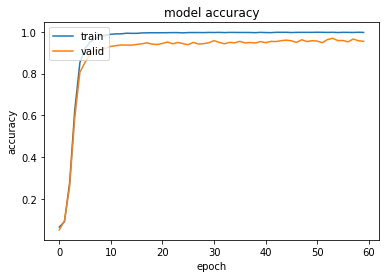

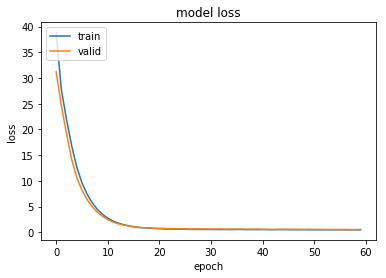

In [35]:
plt.figure(1)
plot_accuracy_curve(final_history)

plt.figure(2)    
plot_loss_curve(final_history)

In [36]:
test_accuracy = final_lenet.eval_accuracy(X_test_preprocessed, y_test)
print("*************** Test Accuracy: {:.1f}% *****************".format(test_accuracy*100))

*************** Test Accuracy: 94.7% *****************


### Use Augmented Samples

In [42]:
from AugmentData import AugmentDataGenerator

#### Visualize Augment Data

In [4]:
adg = AugmentDataGenerator(X_train_preprocessed, y_train)
X_batch, y_batch = adg.next_batch(100)
#visualize_data(X_batch, y_batch, visualize_class_num=5, cmap='gray')

In [78]:
aug_params = {'conv1_num_filters': 32, 'conv2_num_filters': 128,
          'fc1_depth': 2048, 'fc2_depth': 256,
          'lr_start': 1e-3, 
          'l2': 0,#1e-3, 
          'dropout_prob': 1.0,#0.25 
          'use_bn': False,
          'num_epochs': 50#60
             }

aug_lenet_config = LeNetConfig(input_dim, num_classes, aug_params)
batch_size = aug_lenet_config.batch_size
steps_per_epoch = int(len(X_train_preprocessed) / batch_size)
print('steps_per_epoch: {0}'.format(steps_per_epoch))

aug_lenet = LeNet(aug_lenet_config)
adg = AugmentDataGenerator(X_train_preprocessed, y_train)
(aug_history, aug_valid_loss, aug_valid_accuracy) = aug_lenet.fit_generator(adg, steps_per_epoch, X_valid_preprocessed, y_valid)

steps_per_epoch: 271
Training...

EPOCH 1 ...
Train Loss: 3.290023
Train Accuracy = 0.713
Validation Loss = 0.948
Validation Accuracy = 0.732

EPOCH 2 ...
Train Loss: 1.073788
Train Accuracy = 0.815
Validation Loss = 0.570
Validation Accuracy = 0.834

EPOCH 3 ...
Train Loss: 0.843216
Train Accuracy = 0.854
Validation Loss = 0.490
Validation Accuracy = 0.862

EPOCH 4 ...
Train Loss: 0.713738
Train Accuracy = 0.871
Validation Loss = 0.337
Validation Accuracy = 0.902

EPOCH 5 ...
Train Loss: 0.632976
Train Accuracy = 0.892
Validation Loss = 0.361
Validation Accuracy = 0.900

EPOCH 6 ...
Train Loss: 0.578552
Train Accuracy = 0.895
Validation Loss = 0.350
Validation Accuracy = 0.901

EPOCH 7 ...
Train Loss: 0.534128
Train Accuracy = 0.906
Validation Loss = 0.364
Validation Accuracy = 0.909

EPOCH 8 ...
Train Loss: 0.492167
Train Accuracy = 0.916
Validation Loss = 0.399
Validation Accuracy = 0.900

EPOCH 9 ...
Train Loss: 0.457432
Train Accuracy = 0.919
Validation Loss = 0.363
Validation Acc

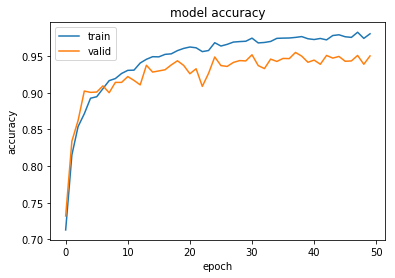

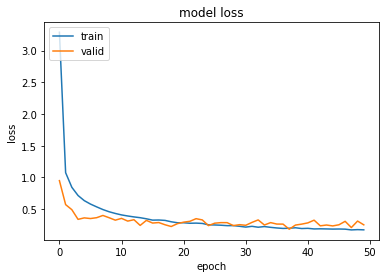

In [79]:
plt.figure(1)
plot_accuracy_curve(aug_history)

plt.figure(2)    
plot_loss_curve(aug_history)

In [82]:
# aug_test_accuracy = aug_lenet.eval_accuracy(X_test_preprocessed, y_test)
# print("*************** Test Accuracy: {:.1f}% *****************".format(aug_test_accuracy*100))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

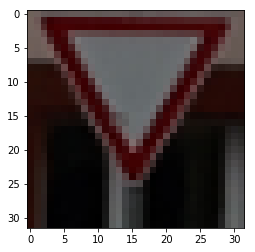

In [70]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
image1 = mpimg.imread('data/web/01-speed-limit-30-1.png')
image2 = mpimg.imread('data/web/12-priority-road-1.png')
image3 = mpimg.imread('data/web/13-yield-1.png')

plt.imshow(image3)

#print(image.shape)


### Predict the Sign Type for Each Image

In [2]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

X_web = np.array([image1, image2, image3])


#plt.imshow(X_web[0], cmap='gray')
#X_web = rgb2gray(X_web / 255.0)
X_web = rgb2gray(X_web)

#print(X_web[0].shape)
#print(X_train[0].shape)
#print(X_web[0])
#print(X_train[0])
#plt.imshow(X_web[0], cmap='gray')
X_web = preprocess_chain(X_web, mean, std)
#print(X_web[0])
#print(X_web[0].shape)
#print(X_train_preprocessed[0].shape)
#plt.imshow(X_web[0], cmap='gray')

#plt.imshow(X_train, cmap='gray')

web_predicted_classes = final_lenet.predict_class(X_web)
print(web_predicted_classes)

aug_web_predicted_classes = aug_lenet.predict_class(X_web)
print(aug_web_predicted_classes)


web_predicted_probabilities = final_lenet.predict_probabilities(X_web)
#print(web_predicted_probabilities)


aug_web_predicted_probabilities = aug_lenet.predict_probabilities(X_web)
#print(aug_web_predicted_probabilities)




### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [81]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, leNet, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = np.reshape(image_input, (1,*image_input.shape))
    #image_input = rgb2gray(image_input / 255.0)
    #image_input = preprocess_chain(image_input)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    activation = leNet.activation(image_input, tf_activation)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Tensor("relu1:0", shape=(?, 28, 28, 6), dtype=float32)


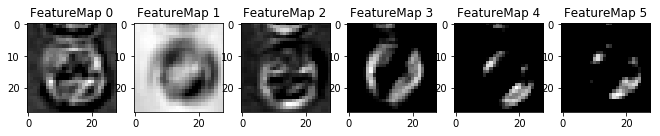

In [89]:
#outputFeatureMap(image1, lenet, 'conv1')
outputFeatureMap(X_train_preprocessed[0], lenet, 'relu1')

Tensor("conv1:0", shape=(?, 28, 28, 6), dtype=float32)


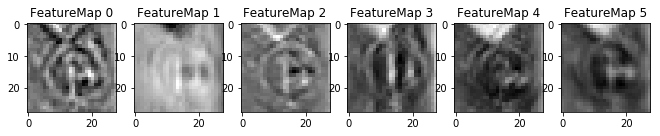

In [87]:
outputFeatureMap(X_train_preprocessed[1000], lenet, 'conv1')

Tensor("conv1:0", shape=(?, 28, 28, 6), dtype=float32)


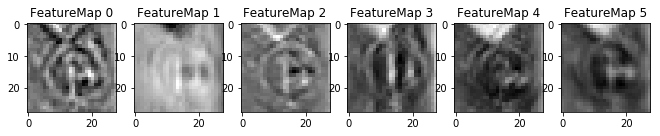

In [88]:
outputFeatureMap(X_train_preprocessed[1000], lenet, 'conv1')

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 